### Emulator

In [2]:
import xarray as xr

DATADIR = '../data'

def get_period_from_qbo(file):
    ds = xr.open_dataset(file,decode_times=False)
    ds = ds.sel(pfull=slice(5,70))
    ds.close()

In [3]:
ds = xr.open_dataset("../data/0_QBO_20_40.nc",decode_times=False)

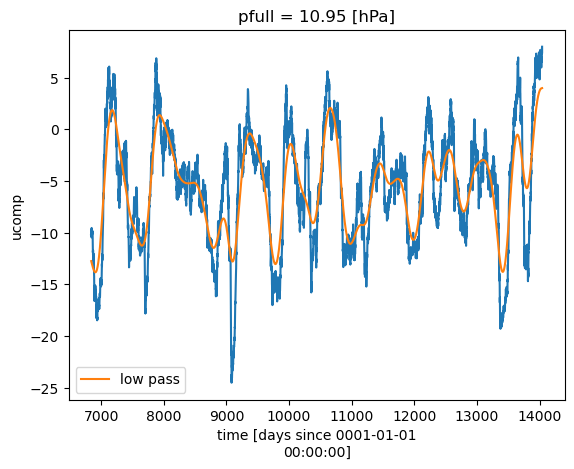

In [4]:
from scipy.signal import filtfilt,butter
import matplotlib.pyplot as plt
for x in ds.sel(pfull=slice(10,70)).ucomp.transpose():
    b,a = butter(2,0.005,btype='low',analog=False)
    x.plot()
    filt = filtfilt(b,a,x)
    plt.plot(x.time,filt,label="low pass")
    plt.legend()
    break